## Created nate_branch for phase 2 group project

## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


Possible stakeholder:
Here's how much your home will sell for. Ask Shane about standard average  asking price -  haggle price = closing price so we can adjust our recommendation up that percent 
say asking_price = 100,000 and buyer haggles to 90,000, we would factor that in and recommend asking_price be 110,000

object to datetime for this purpose. ['yr_renovated'] has 3842 Null values.

our price mean is 540296.5735055795

['price'] and ['zipcode'] have a very low correlation of -0.05340243437772487

Top correlations with price
sqft_living = 0.70
grade = 0.66
sqft_above = 0.60
sqft_living15 = 0.58


['yr_renovated'] has something in it that the second_model doesn't like

In [1]:
# Import the necessary libraries


import pandas as pd 
import matplotlib.pyplot as plt
import math
from math import gamma
import scipy as sp
import numpy as np
from matplotlib.lines import Line2D
import itertools
from scipy import stats
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import seaborn as sns
from collections import Counter
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans, AgglomerativeClustering

from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn import datasets
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler, QuantileTransformer, PolynomialFeatures 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, RFE
#validation libraries
from IPython.display import display
from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# read the data into a variable called data
data = pd.read_csv('data/kc_house_data.csv')

# make a copy of data to work with calle df
df = data.copy(deep=True)

# converted dates from object to datetime
df.date = pd.to_datetime(df.date,infer_datetime_format=True) # Monday trying Arthur's month formula
df['date']=df['date'].apply(lambda x: x.toordinal())

# Arthur's 
df['month_of_date'] = pd.DatetimeIndex(df['date']).month

# getting rid of a question mark in one of the columns
df['sqft_basement'] = df['sqft_basement'].replace({'?':np.nan}).astype(float)


# get rid of those pesky NaN
df['yr_renovated'] = df['yr_renovated'].fillna(0)

# convert to log_price 
df['log_price'] = np.log(df['price']) #$$$$$$

# removing normalized price from our log_price df
df.drop(['price'], axis=1, inplace=True) #$$$$$

df['view'] = df['view'].fillna(0)

# df.rename(columns={'floors_1.5': 'floors_1_5', 'floors_2.0': 'floors_2', 'floors_2.5': 'floors_2_5',
#                    'floors_3.0': 'floors_3', 'floors_3.5': 'floors_3_5'}, inplace=True)

# df = pd.get_dummies(df, prefix='floors', prefix_sep='_', columns=['floors'], drop_first = True)
# df = pd.get_dummies(df, prefix='waterfront', prefix_sep='_', columns=['waterfront'], drop_first = True)
# df = pd.get_dummies(df, prefix='view', prefix_sep='_', columns=['view'], drop_first = True)
# df = pd.get_dummies(df, prefix='condition', prefix_sep='_', columns=['condition'], drop_first = True)
# df = pd.get_dummies(df, prefix='grade', prefix_sep='_', columns=['grade'], drop_first = True)
# df = pd.get_dummies(df, prefix='month', prefix_sep='_', columns=['month_of_date'], drop_first = True)
# df = pd.get_dummies(df, prefix='zipcode', prefix_sep='_', columns=['zipcode'], drop_first = True)

# check log_price minimum
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_of_date,log_price
0,7129300520,735519,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,1,12.309982
1,6414100192,735576,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,1,13.195614
2,5631500400,735654,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,1,12.100712
3,2487200875,735576,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,1,13.311329
4,1954400510,735647,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,1,13.142166


In [3]:
# df.waterfront = df.waterfront.fillna(0)

# df_dummies = pd.get_dummies(df, prefix='waterfront', prefix_sep='_',
#                            columns=['waterfront'], drop_first = True)
# dummy_waterfront = df_dummies['waterfront_1.0']


# df_dummies['dummy_waterfront'] = dummy_waterfront

# df_dummies.drop('waterfront_1.0', axis=1, inplace=True)

# df_dummies.head()
# #df.head()


## Adjusting Longitude and Latitude

In [4]:
# Now to deal with longitude and latitude
# Round off after the decimal to help our model 
# df = df.round({"long":4, "lat":4})

# **A second option to deal with long and lat**
# Change long and lat to radians instead of degrees
df["long"] = np.radians(df["long"])
df["lat"] = np.radians(df["lat"])

## KMeans color clustering the map

In [5]:
# k means
# https://towardsdatascience.com/visualizing-clusters-with-pythons-matplolib-35ae03d87489
kmeans = KMeans(n_clusters=3, random_state=0)
df['cluster'] = kmeans.fit_predict(df[['lat', 'long']])
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
df['cen_x'] = df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
df['cen_y'] = df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
df['c'] = df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

# Assigning our model variables 

In [6]:
dropped_cols_for_work = [ 'id','sqft_lot', 'floors'
                ,'waterfront', 'yr_built','sqft_basement', 'date'
            ,'zipcode', 'yr_renovated', 'bathrooms', 'cen_x', 'cen_y']
#X_train.waterfront.value_counts()

In [7]:
y_reg = data.price
y = df.log_price  #changed log_price to log Sunday night 8:40
X = df.drop('log_price', axis=1) #changed log_price to log Sunday night 8:40

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2) # ,random_state=10) if you want the samples to stay the same each time

# X_train.drop(['date'], axis=1, inplace=True)
# X_test.drop(['date'], axis=1, inplace=True)

# # changed ? in ['sqft_basement to NaN']
# X_train['sqft_basement'] = X_train['sqft_basement'].replace({'?':np.nan}).astype(float)
# X_test['sqft_basement'] = X_test['sqft_basement'].replace({'?':np.nan}).astype(float)
X_train.tail(5)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_of_date,cluster,cen_x,cen_y,c
18144,1825079086,735374,4,2.50,3010,46173,2.0,0.0,0.0,3,9,3010,0.0,1996,0.0,98053,0.831599,-2.128673,2590,49222,1,2,0.830981,-2.129933,#2095DF
1962,8637100370,735549,3,2.00,1340,5670,2.0,NaN,0.0,3,6,1340,0.0,1994,0.0,98055,0.828155,-2.132688,1290,4892,1,0,0.827112,-2.132830,#DF2020
9149,6021501635,735539,4,2.50,2560,4000,2.0,0.0,0.0,5,8,1610,950.0,1929,0.0,98117,0.832321,-2.136039,1760,4000,1,1,0.831591,-2.134709,#81DF20
21370,774101755,735705,3,1.75,1790,66250,1.5,0.0,0.0,3,7,1790,0.0,2003,0.0,98014,0.832834,-2.118882,1440,59346,1,2,0.830981,-2.129933,#2095DF
7289,2780700020,735486,4,2.50,1900,9428,2.0,0.0,0.0,3,8,1900,0.0,1978,0.0,98028,0.833618,-2.133560,1830,10480,1,1,0.831591,-2.134709,#81DF20


## Plotting out the locations of our homes over a map of King Co.

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


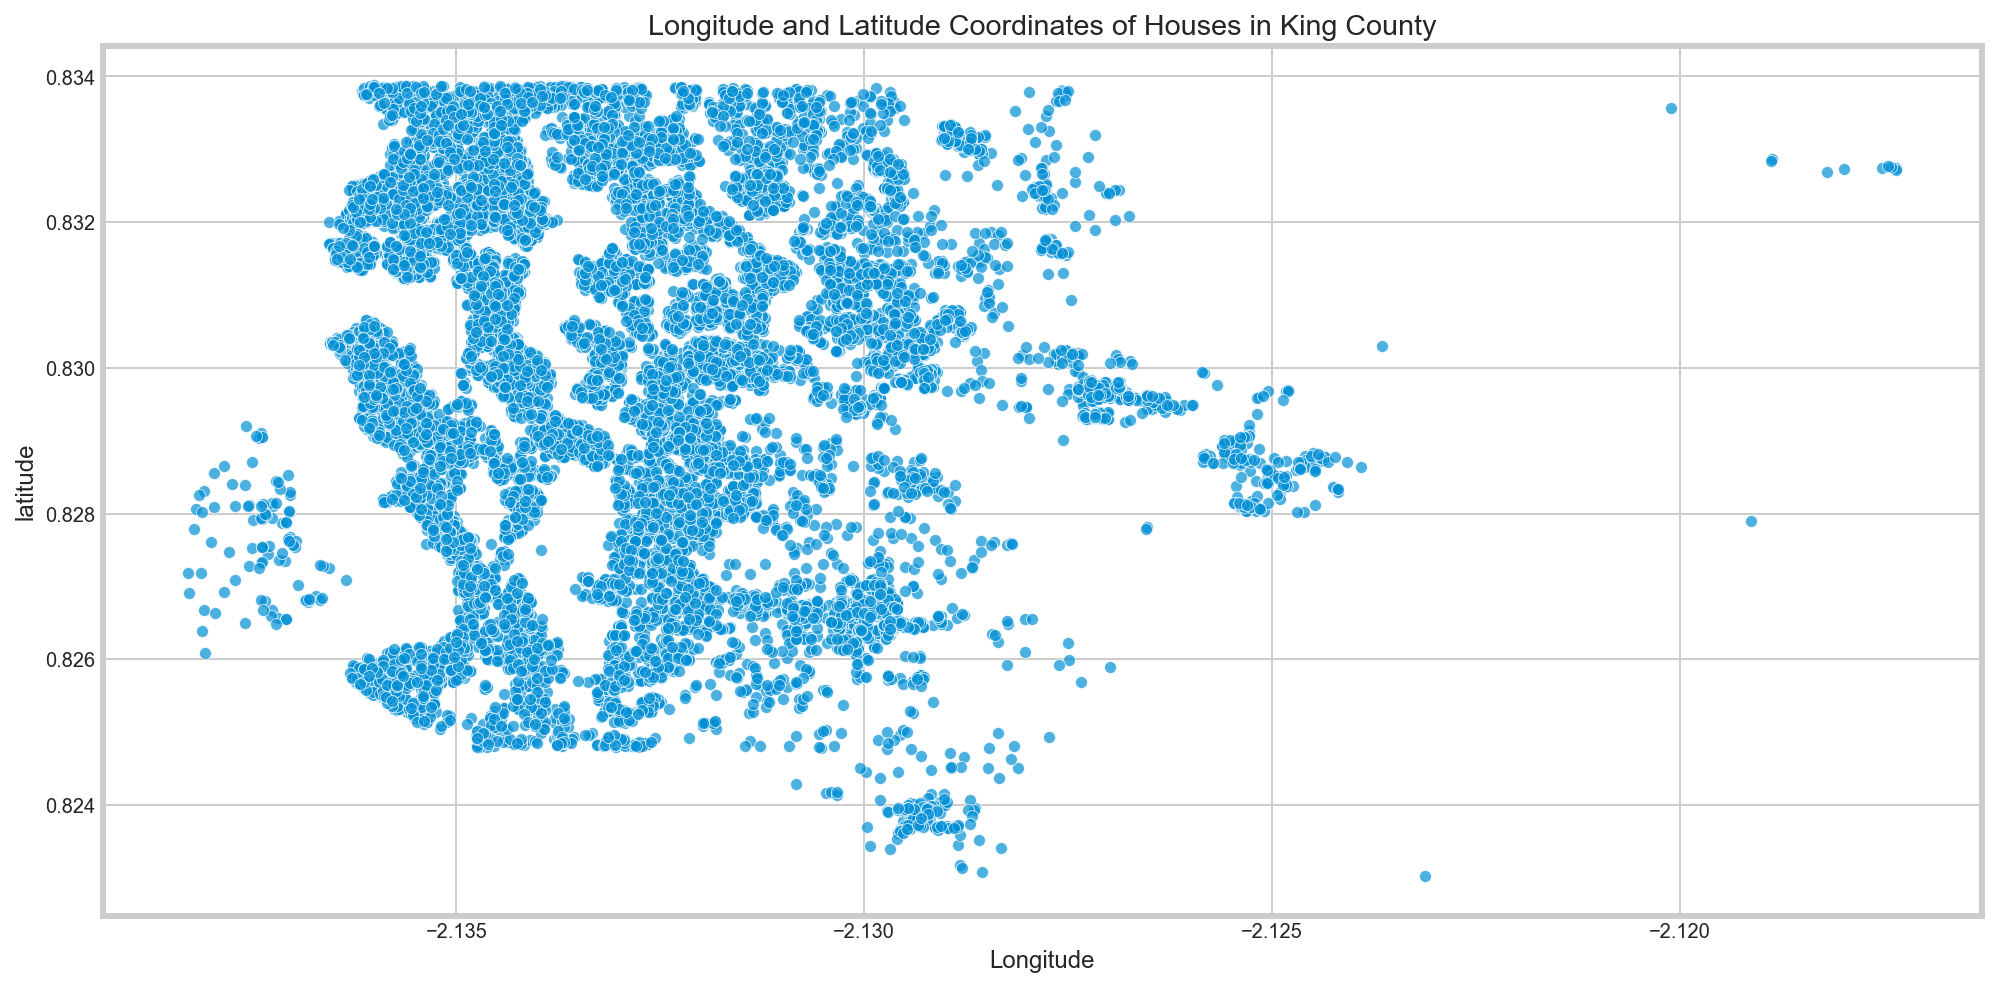

In [8]:
fig, ax = plt.subplots(figsize = (15,8))
sns.scatterplot(X_train.long, X_train.lat, alpha=.7);

plt.title('Longitude and Latitude Coordinates of Houses in King County')
plt.xlabel('Longitude')
plt.ylabel('latitude');

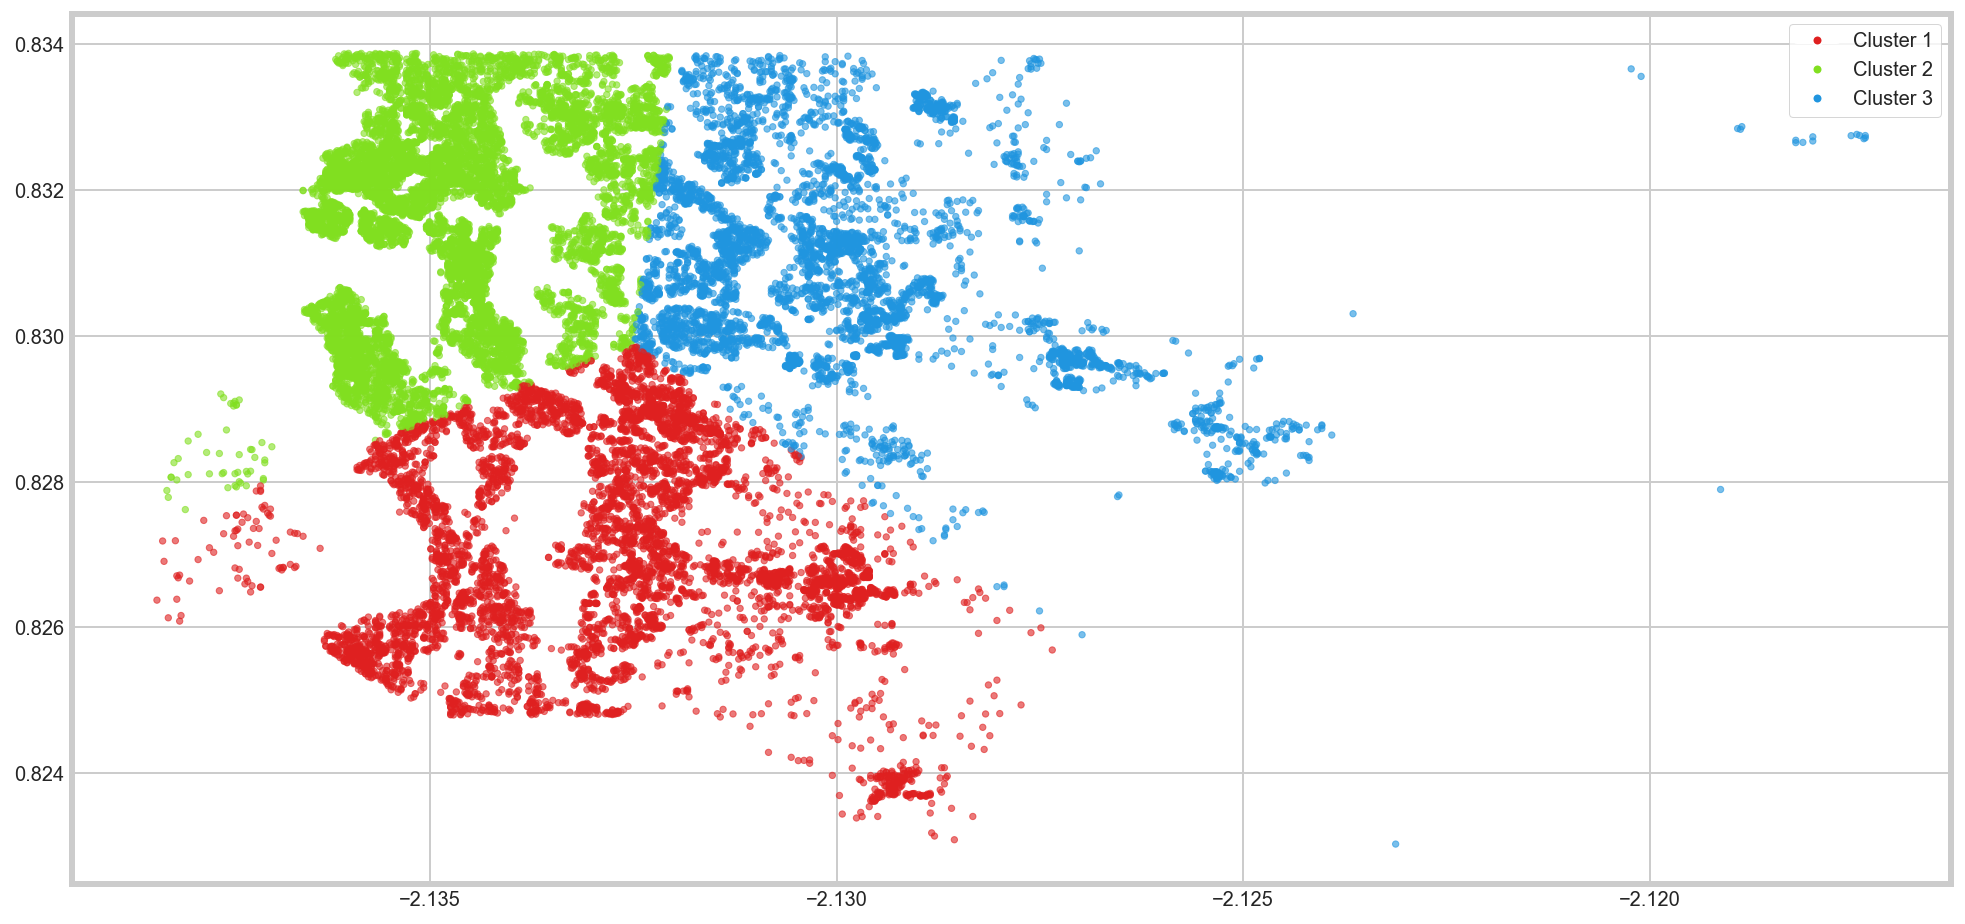

In [9]:
plt.figure(figsize=(15,8))

plt.scatter(df.long, df.lat, c=df.c, alpha = 0.6, s=10,)

# create a list of legend elemntes
## markers / records
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]

plt.legend(handles=legend_elements, loc='upper right');

## A heatmap to help inspect correlation

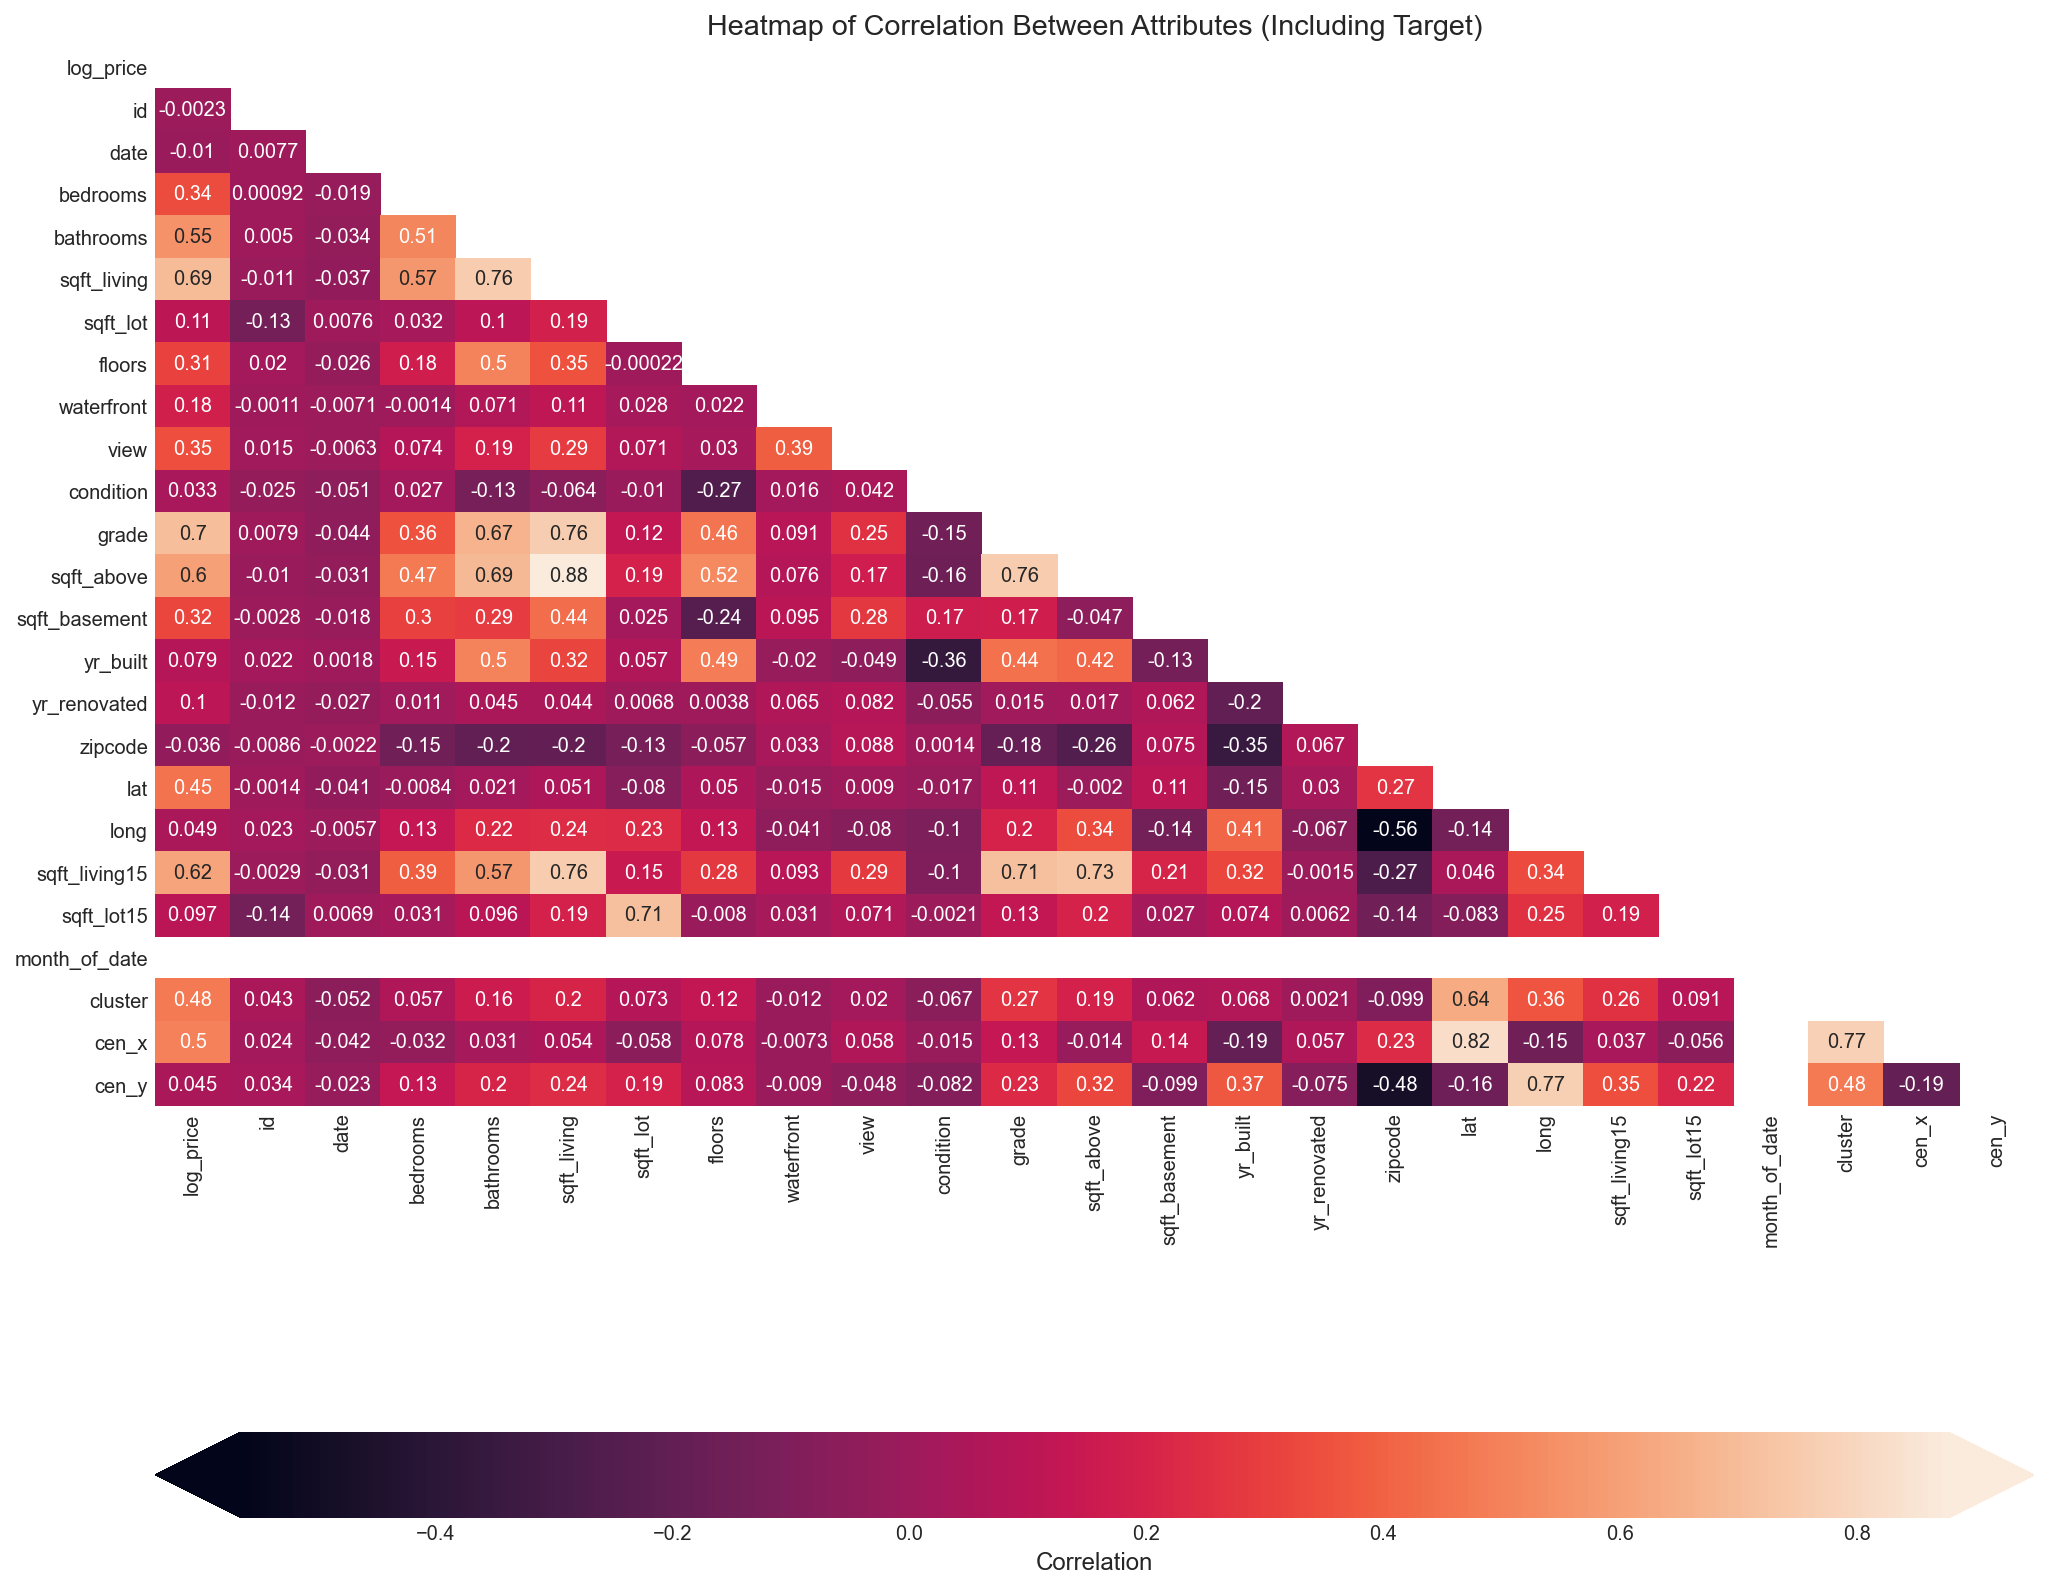

In [10]:
# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = pd.concat([y_train, X_train], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

## Correlation amung the features

In [11]:
# bedrooms
# sqft_living
# condition
# grade
# lat
# sqft_living15
# view
# sqft_above

In [12]:
print(data.price.min())
print(data.price.max())

78000.0
7700000.0


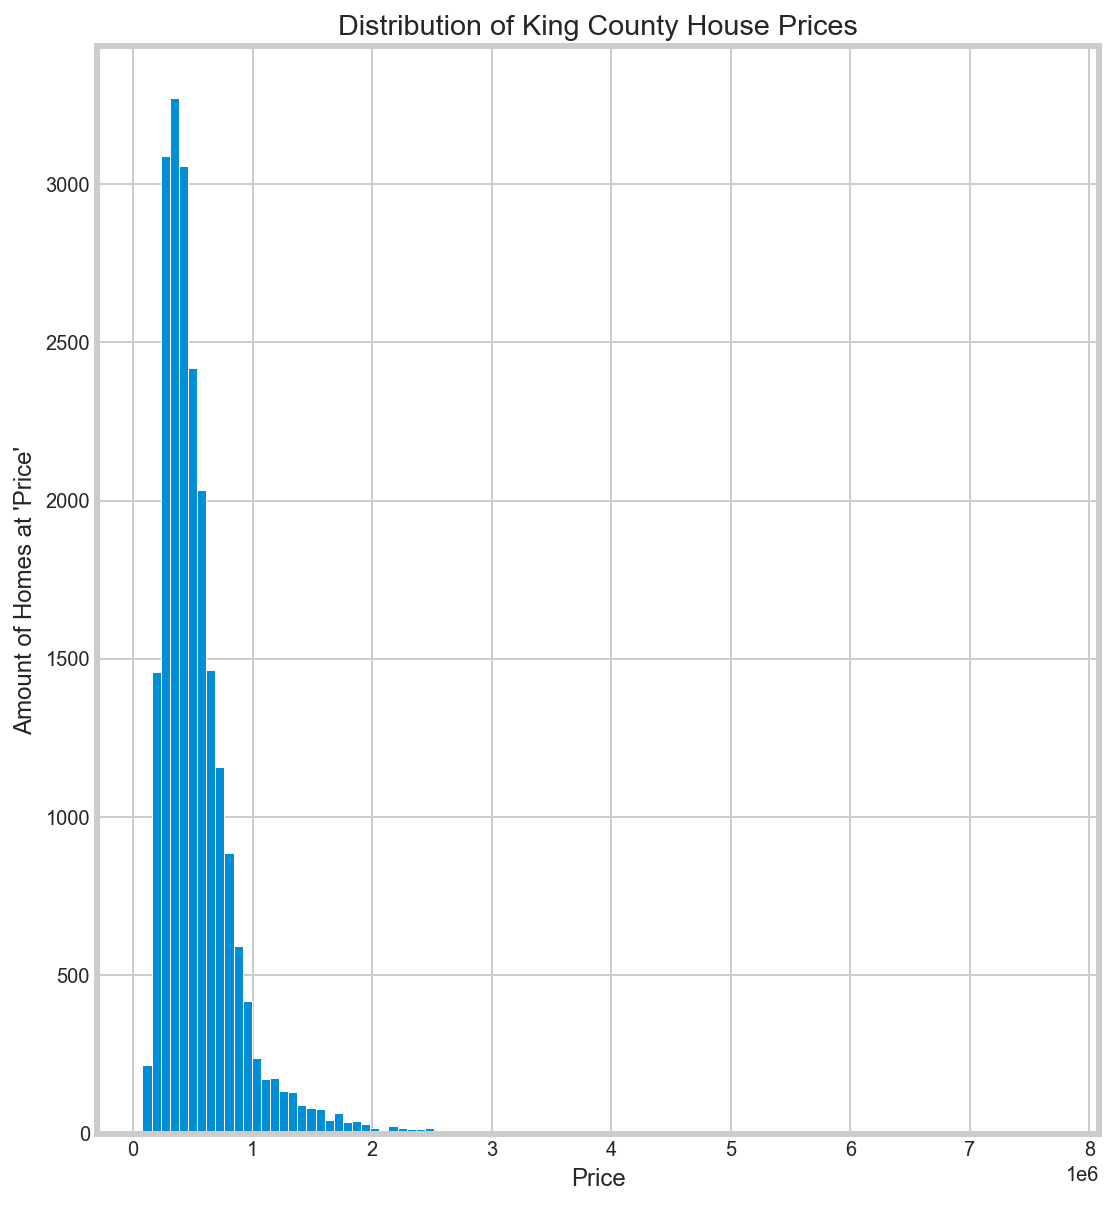

In [13]:
fig, ax = plt.subplots(figsize=(8, 10))

ax.hist(y_reg, bins=100)

ax.set_xlabel("Price")
ax.set_ylabel("Amount of Homes at 'Price'")
ax.set_title("Distribution of King County House Prices");

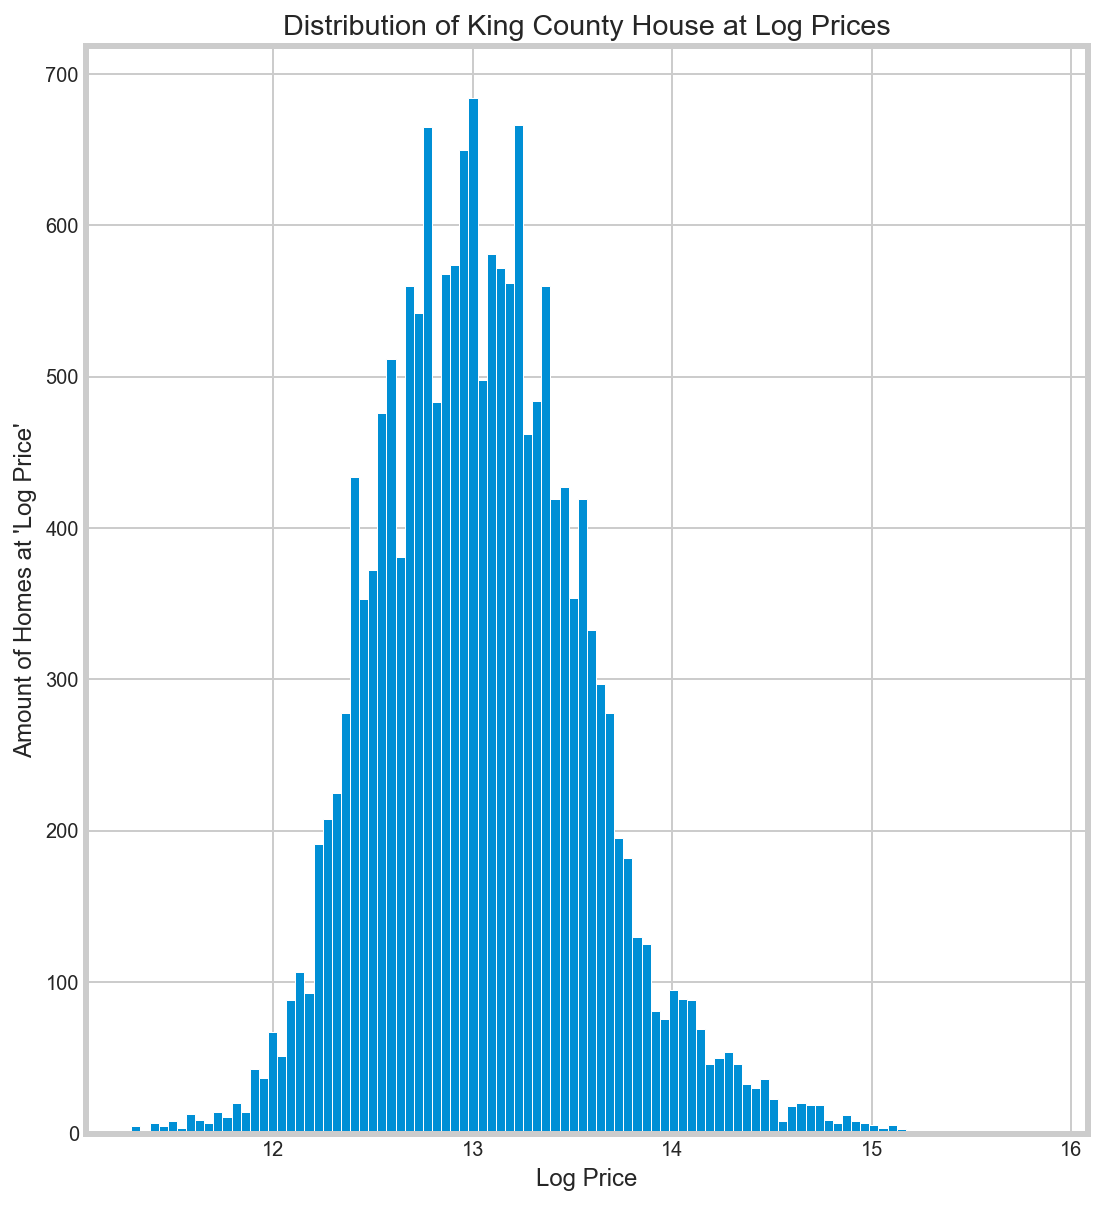

In [14]:
fig, ax = plt.subplots(figsize=(8, 10))

ax.hist(y_train, bins=100)

ax.set_xlabel("Log Price")
ax.set_ylabel("Amount of Homes at 'Log Price'")
ax.set_title("Distribution of King County House at Log Prices");

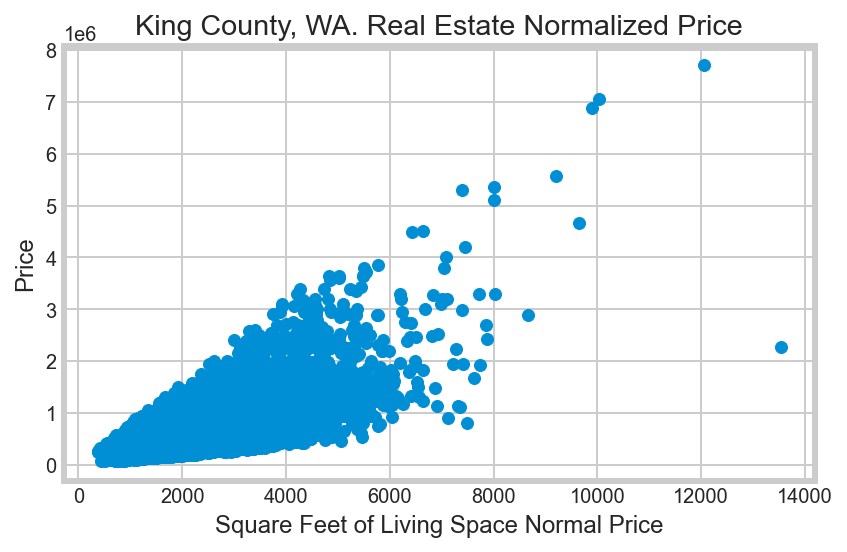

In [15]:
plt.scatter(df['sqft_living'], data['price'])
plt.title('King County, WA. Real Estate Normalized Price')
plt.xlabel('Square Feet of Living Space Normal Price')
plt.ylabel('Price');

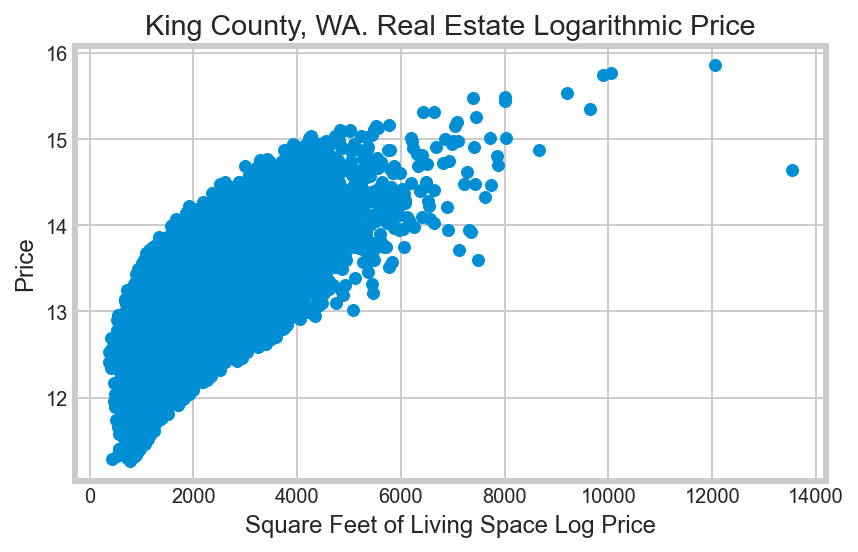

In [16]:
plt.scatter(df['sqft_living'], df['log_price']) # changed log_price to price Sunday night 8:40
plt.title('King County, WA. Real Estate Logarithmic Price')
plt.xlabel('Square Feet of Living Space Log Price')
plt.ylabel('Price');

In [17]:
most_correlated_feature = 'sqft_living'

In [18]:
baseline_model = LinearRegression()

## Model number one

In [19]:
splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train[[most_correlated_feature]],
    y=y_train,
    return_train_score=True, 
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.47829177852007737
Validation score: 0.48708757257183977


##  Let's have a look at only numeric columns shall we?

In [20]:
X_train_numeric = X_train.select_dtypes(include=['int64', 'float64'])

X_train_numeric.isnull().sum()

id                  0
date                0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1888
view                0
condition           0
grade               0
sqft_above          0
sqft_basement     371
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
month_of_date       0
cen_x               0
cen_y               0
dtype: int64

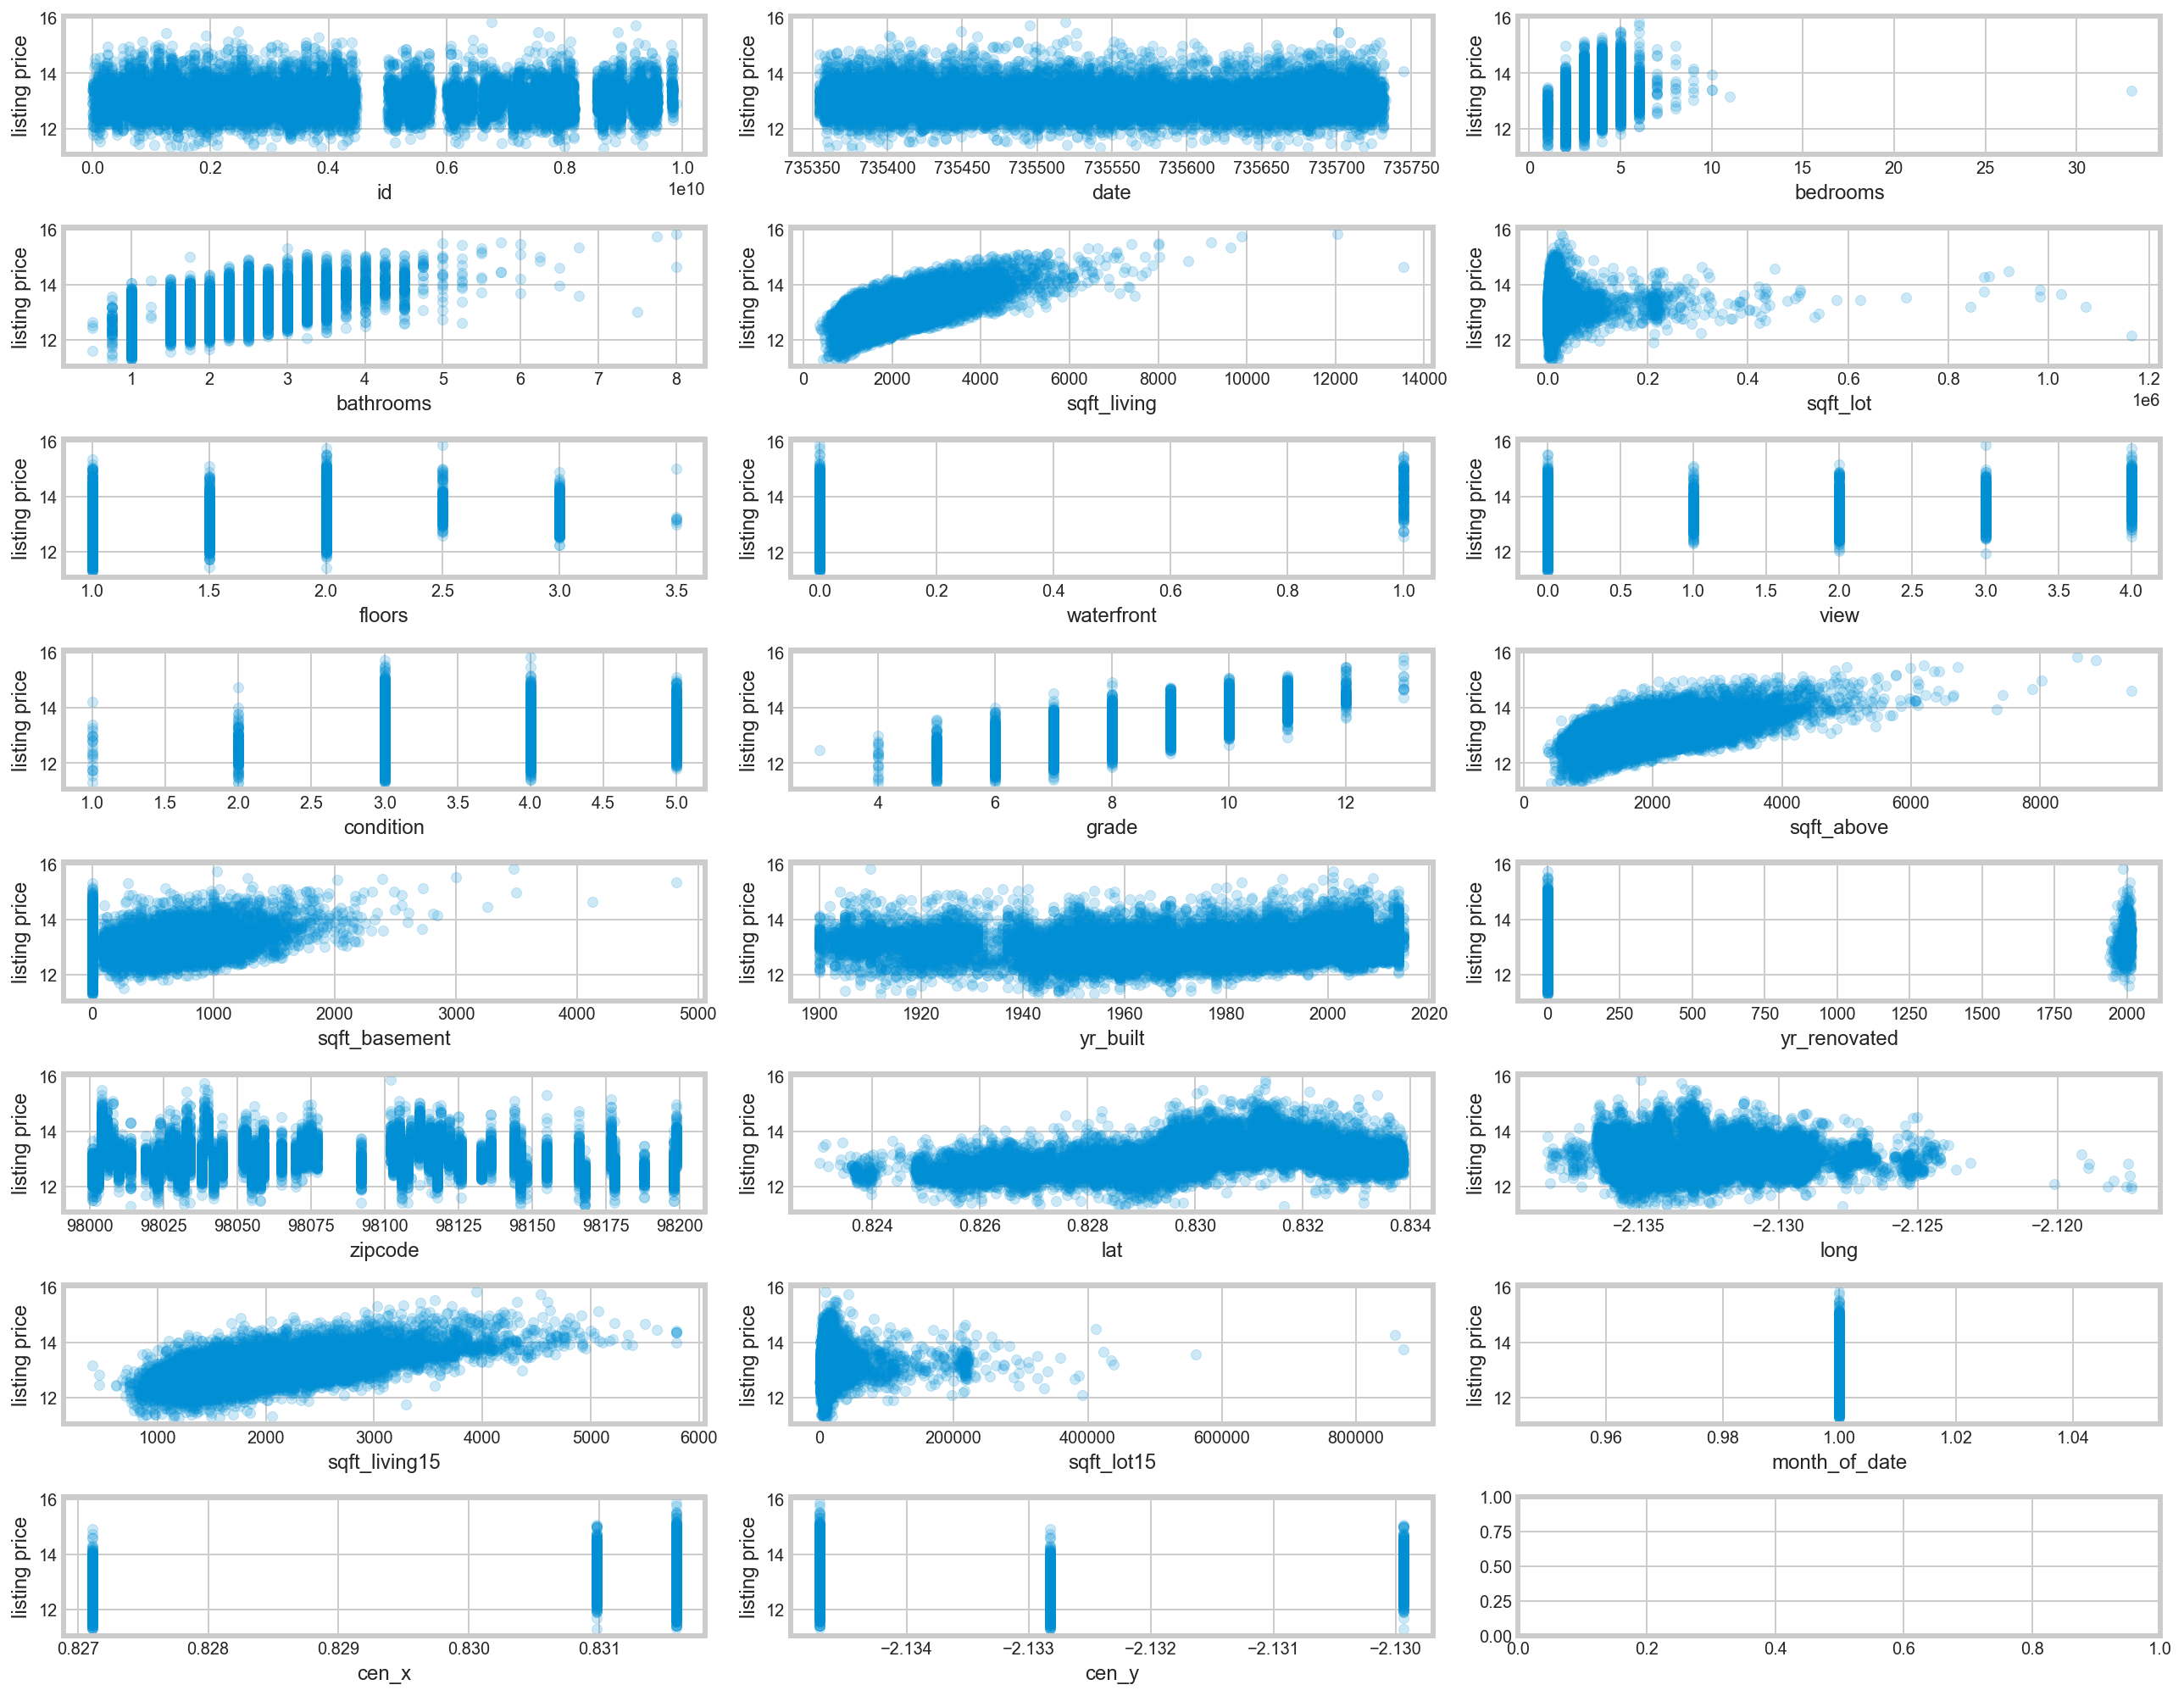

In [21]:
fig, axes = plt.subplots(ncols=3, nrows=8, figsize=(18, 14))
fig.set_tight_layout(True)

for index, col in enumerate(X_train_numeric.columns):
    ax = axes[index//3][index%3]
    ax.scatter(X_train_numeric[col], y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("listing price")

In [22]:
X_train_second_model = X_train_numeric.drop(columns = [ 'id','sqft_lot', 'floors'
                                                       ,'waterfront', 'yr_built','sqft_basement', 'date'
                                                       ,'zipcode', 'yr_renovated', 'bathrooms', 'cen_x', 'cen_y'])
X_train_second_model.head()

# ****view has something in it that the model doesn't like****

# bedrooms
# sqft_living
# grade
# lat
# sqft_living15
#'sqft_above'
# condition



,bedrooms,sqft_living,view,condition,grade,sqft_above,lat,long,sqft_living15,sqft_lot15,month_of_date
8665,2,1730,0.0,4,6,1730,0.829654,-2.135724,1180,6250,1
3984,3,1980,0.0,3,7,1470,0.831927,-2.135742,1500,1873,1
19753,3,1260,0.0,3,7,1040,0.832716,-2.135079,1260,1472,1
9979,3,1680,0.0,4,7,1680,0.830826,-2.132216,1880,7770,1
11395,3,850,0.0,3,6,850,0.833292,-2.134782,1150,6907,1


## Second model

In [23]:
second_model = LinearRegression()

second_model_scores = cross_validate(
    estimator=second_model,
    X=X_train_second_model,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.7417146225628266
Validation score: 0.7442282612312511

Baseline Model
Train score:      0.47829177852007737
Validation score: 0.48708757257183977


Given the fact that the Train Scores and Validation Scores are relatively near to eachother, it may be said that there is very little multicollinearity in the second_model

## Tests from Sunday morning (after data loss debacle and recovery), July 11th

## Tests from Saturday night, July 10th

## Test with Lat and Long excluded

In [24]:
# from sklearn.linear_model import LinearRegression
# linreg = LinearRegression()
# linreg.fit(X_train_second_model, y_train)

# y_hat_train = linreg.predict(X_train)
# y_hat_test = linreg.predict(X_test)

## OLS and the search for multicollinearity

In [25]:
sm.OLS(y_train, sm.add_constant(X_train_second_model)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     4977.
Date:                Mon, 12 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:59:28   Log-Likelihood:                -1708.2
No. Observations:               17277   AIC:                             3438.
Df Residuals:                   17266   BIC:                             3524.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms         -0.0036      0.003     -1.335      0.182      -0.009       0.002
sqft_living       0.0002   5.74e-06     30.866      0.000       0.000       0.000
view              0.0857      0.003     29.451      0.000       0.080       0.091
condition         0.0905      0.003     27.804      0.000       0.084       0.097
grade             0.1465      0.003     48.830      0.000       0.141       0.152
sqft_above     9.751e-06   5.75e-06      1.696      0.090   -1.52e-06     2.1e-05
lat              83.7984      0.867     96.702      0.000      82.100      85.497
long            -13.5650      0.951    -14.268      0.000     -15.428     -11.701
sqft_living15  9.091e-05   5.03e-06     18.082      0.000    8.11e-05       0.000
sqft_lot15     1.963e-07   7.74e-08      2.537      0.011    4.46e-08    3.48e-07
month_of_date   -87.4530      2.068    -42.285      0.000     -91.507     -83.399
==============================================================================
Omnibus:                      230.703   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              399.765
Skew:                           0.083   Prob(JB):                     1.56e-87
Kurtosis:                       3.727   Cond. No.                     3.40e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.4e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
X_train_for_RFECV = StandardScaler().fit_transform(X_train_second_model)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)

# Print the results
print("Was the column selected?")
for index, col in enumerate(X_train_second_model.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
bedrooms: True
sqft_living: True
view: True
condition: True
grade: True
sqft_above: True
lat: True
long: True
sqft_living15: True
sqft_lot15: True
month_of_date: False


# Third Model

#### chekcing for correlation between Features

In [27]:
# print(df[["bedrooms","sqft_living"]].corr()) # .57
# print(df[["bedrooms","condition"]].corr())# .02
# print(df[["bedrooms","grade"]].corr())# .35
# print(df[["bedrooms","lat"]].corr())# .009
# print(df[["bedrooms","sqft_living15"]].corr()) # .39
# print(df[["bedrooms","view"]].corr())# .07 
# print(df[["bedrooms","sqft_above"]].corr())# .47

# print(df[["sqft_living","condition"]].corr()) # .05
# print(df[["sqft_living","grade"]].corr()) # .76 ***********high
# print(df[["sqft_living","lat"]].corr()) # .05
# print(df[["sqft_living","sqft_living15"]].corr()) # .75 ********high
# print(df[["sqft_living","view"]].corr()) # .28 
# print(df[["sqft_living","sqft_above"]].corr()) # .87 ********high

# print(df[["condition","grade"]].corr()) # -.14
# print(df[["condition","lat"]].corr()) # -.015
# print(df[["condition","sqft_living15"]].corr()) # -.09
# print(df[["condition","view"]].corr()) # .04 
# print(df[["condition","sqft_above"]].corr()) # - .10

# print(df[["grade","lat"]].corr()) # .11
# print(df[["grade","sqft_living15"]].corr()) # .71 *****high
# print(df[["grade","view"]].corr()) # .24 
# print(df[["grade","sqft_above"]].corr()) # .75 ********high

# print(df[["lat","sqft_living15"]].corr()) # .04
# print(df[["lat","view"]].corr()) # .006 
# print(df[["lat","sqft_above"]].corr()) # -.001

# print(df[["sqft_living15","view"]].corr()) # .27 
# print(df[["sqft_living15","sqft_above"]].corr()) # .73********high

# sqft_living and waterfront are lower than sqft_living an view

## Selecting best features

In [28]:
best_features = ['sqft_living', 'view', 'lat'] # minus condition
#bedrooms
# sqft_living
# grade
# lat
# sqft_living15
#'sqft_above'
# condition


In [29]:
X_train_final = X_train[best_features]
X_test_final = X_test[best_features]

###  R - Squared 

In [30]:
final_model = LinearRegression()

# fit the model on X_train_final and y_train
final_model.fit(X_train_final, y_train)

# Score the model on X_test_final and y_train
final_model.score(X_test_final, y_test)

0.684221341131096

### Mean Squared Error (MSE)

In [31]:
mean_squared_error(y_test, final_model.predict(X_test_final), squared=False)

0.2963847755986736

In [32]:
# Run this cell without changes
print(pd.Series(final_model.coef_, index=X_train_final.columns, name="Coefficients"))
print()
print("Intercept:", final_model.intercept_)

sqft_living     0.000357
view            0.112158
lat            90.798640
Name: Coefficients, dtype: float64

Intercept: -63.0912433143696


### Investigating Linearity

In [33]:
y_test.min()

11.26446410567173

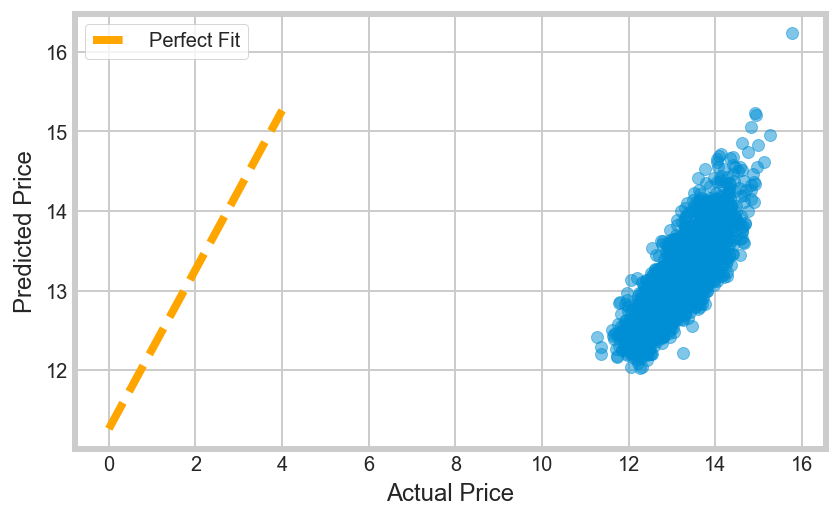

In [34]:
preds = final_model.predict(X_test_final) # commented out this line along with below change 
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line,linestyle="--", color="orange", label="Perfect Fit") # perfect_line, ***removed this from round bracket first position
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

## QQ plot (Quantile-Quantile)

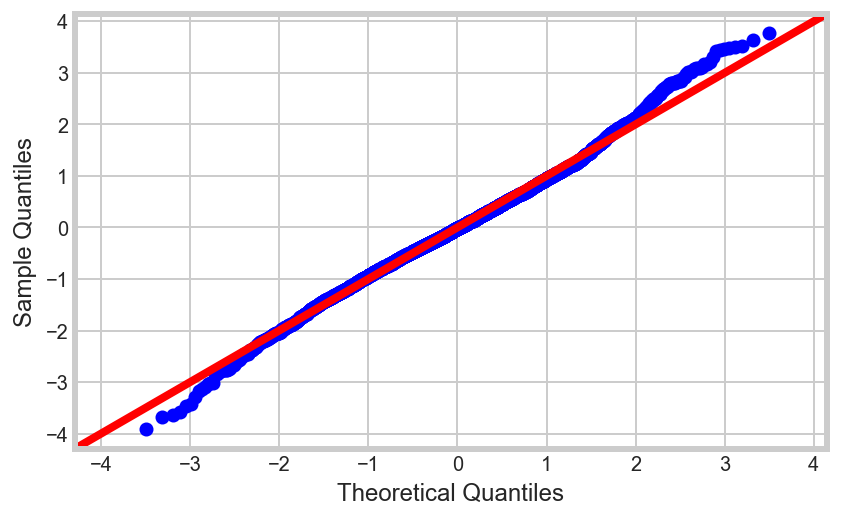

In [35]:
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

### Variance Inflation Factor (Above 5 is bad for your health)

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X_train_final.values, i) for i in range(X_train_final.shape[1])]
pd.Series(vif, index=X_train_final.columns, name="Variance Inflation Factor")

sqft_living    6.629666
view           1.192760
lat            6.210797
Name: Variance Inflation Factor, dtype: float64

###  Homeoscedasticity Check

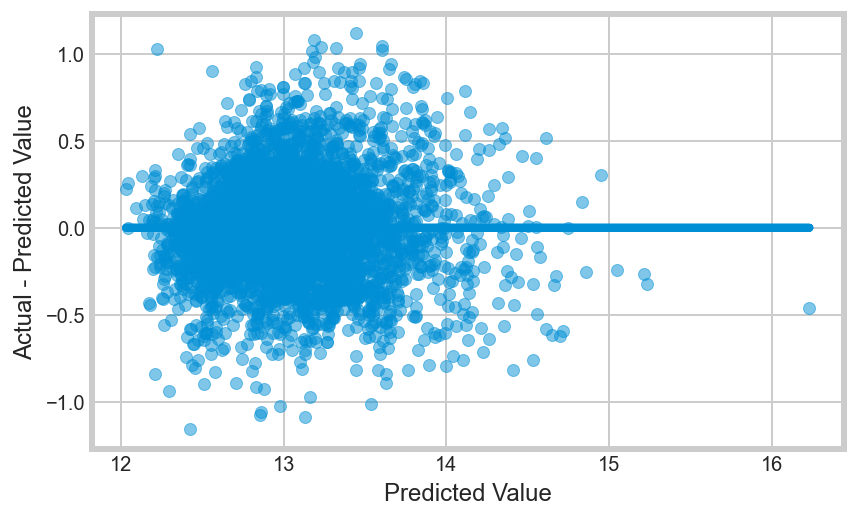

In [37]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

In [38]:
Include at least 2 important parameter estimates in your final recommendations
Folium/Geopandas

SyntaxError: invalid syntax (<ipython-input-38-ebdb961396e8>, line 1)

In [ ]:
<img src=https://static.seattletimes.com/wp-content/uploads/2019/02/02062019_housing_160430-780x471.jpg width="1100" height="400">

# A Regression Model that Appraise Homes remotely for ACME Bank

**Authors**: Nate Walter, Douglas Lu, Shane Mangold. Arthur Kim

* [Overview](#Overview)


* [Business Problem](#Business-Problem)


* [The Data](#The-Data)


* [Methods](#methods)




## Overview
This project predicts house prices for King County, Washington based on an existing dataset using 
regression modeling. Our findings will help ACME bank make home appraisles wihtout the need for a 
bank employee to enter the domicile. ACME can then use the predictions
to set sales prices for homes to be put on the market at competitive market values based on the
regression model's predictions.

<img src=https://user-images.githubusercontent.com/66656063/125619329-48319b12-7456-46a7-b4a4-e27a6babbc6f.png width="500" height="300">

http://seattlemag.com/sites/default/files/field/image/iStock-471370245.jpg 
## Business Problem
A recent wave of COVID-related foreclosures has ACME Bank choose an alternative method to having an appraiser 
physically enter homes for inspection, so as to limit liability of employees being exposed to COVID-19. 
Instead, they have come to Group One Inc. for an accurate regression model predicting sales prices for each of their properties. 


## The Data
The Dataset used is from King County, Washington between May 2014 and May 2015. It includes housing sales prices 
along with other descriptive information invovling the properties. 

* https://www.kaggle.com/harlfoxem/housesalesprediction


## Methods
This project uses  multiple linear regression in combination with feature engineering, recurssive feture illimination, 
and dummie regression to predict an unkown house's sales price, all while adhering to the assumptions of linear regression. 
Test are performed to discover any linear relationship between the dependent and independent variables. Multicollinearity is 
examined between the inependent variables. The normal distribution of errors and homeoscedasticity are also omni-present goals to be met.  
Our model uses train-test split which allows us to evaluate whether it has the right balance of bias and variance. 
We use data visualization via Matplotlib and Seaborn taking advantage of histograms, heatmaaps and scatter plots to 
help in the exploritory data analysis process as well as evaluation and presentation. The three questions explored are:

**1)** What features must be dropped to make an accurate predictive model?

**2)** How accurate is our model to the true price of a King County home?

**3)** Can our predictions substitute for in person appraisal?


